## Belousov-Zhabotinsky reaction

We would like to solve this system

$$
    \begin{cases}
        \dot{y}_1 = \alpha - (\beta+1)y_1 + y_1^2 y_2 \\
        \dot{y}_2 = \beta y_1 - y_1^2 y_2
    \end{cases}
$$

with $\alpha = 1$ and $\beta = 3$.

In [1]:
%system mkdir -p belousov_zhabotinsky_demo

[]

In [2]:
%%writefile belousov_zhabotinsky_demo/main.cpp

#include <iostream>

#include "ponio/solver.hpp"
#include "ponio/observer.hpp"
#include "ponio/problem.hpp"
#include "ponio/runge_kutta.hpp"
#include "ponio/eigen_linear_algebra.hpp"

#include <eigen3/Eigen/Dense>

template <typename T>
struct exact_2x2_solver_t
{
    static constexpr std::size_t size = 2;
    using matrix_type = Eigen::Matrix<T, size, size>;
    using vector_type = Eigen::Vector<T, size>;
    
    //// incomplet linear_algebra type
    //static matrix_type
    //identity ( vector_type const& )
    //{
    //  return matrix_type::Identity();
    //}
    
    static vector_type solver (matrix_type const& dfx, vector_type const& fx) {
        T det = dfx(0,0)*dfx(1,1) - dfx(1,0)*dfx(0,1);
        vector_type r;
        r(0) = 1./det*( dfx(1,1)*fx(0) - dfx(0,1)*fx(1) );
        r(1) = 1./det*( dfx(0,0)*fx(1) - dfx(1,0)*fx(0) );
        return r;
    }
};

using exact_2x2_solver = exact_2x2_solver_t<double>;

template <typename T>
struct newton_t
{
    static constexpr std::size_t size = 2;
    using matrix_type = Eigen::Matrix<T, size, size>;
    using vector_type = Eigen::Vector<T, size>;
    
    T tol;
    std::size_t max_iter;
    
    newton_t( std::size_t _max_iter , T _tol )
    : tol(_tol), max_iter(_max_iter)
    {}
    
    static matrix_type
    identity ( vector_type const& )
    {
      return matrix_type::Identity();
    }
        
    vector_type
    _solver (matrix_type const& dfx, vector_type const& fx) {
        T det = dfx(0,0)*dfx(1,1) - dfx(1,0)*dfx(0,1);
        vector_type r;
        r(0) = 1./det*( dfx(1,1)*fx(0) - dfx(0,1)*fx(1) );
        r(1) = 1./det*( dfx(0,0)*fx(1) - dfx(1,0)*fx(0) );
        return r;
    }
    
    T
    _norm( vector_type const& u ) {
        return std::sqrt( u(0)*u(0) + u(1)*u(1) );
    }
    
    template <typename func_t, typename jacobian_t>
    vector_type
    newton ( func_t && f, jacobian_t && df, vector_type const& x0 )
    {
        vector_type xk = x0;
        auto fxk = f(xk);
        T res = _norm(fxk);
        std::size_t count_iter = 0;

        while( count_iter < max_iter && res > tol ) {
            auto increment = _solver(df(xk), -f(xk));

            xk = xk + increment;
            res = _norm(f(xk));

            count_iter += 1;
        }

        return xk;
    }
};

int
main()
{
  using namespace ponio::observer;
  using state_t  = Eigen::Matrix<double, 2, 1>;
  using matrix_t = Eigen::Matrix<double, 2, 2>;
    
  double a=1., b=3.;
    
  auto f = [=](double t, state_t const& u, state_t& du)
  {
      auto & y1 = u[0];
      auto & y2 = u[1];
      
      du[0] = a - (b+1.)*y1 + y1*y1*y2;
      du[1] = b*y1 - y1*y1*y2;
  };
  auto df = [=](double t, state_t const& u) -> matrix_t
  {
      auto & y1 = u[0];
      auto & y2 = u[1];
      
      matrix_t r;
      r <<  2.*y1*y2-(b+1.) ,  y1*y1 ,
           -2.*y1*y2+b      , -y1*y1 ;
      return r;
  };

  state_t u0 = {1.5, 3.};
  double dt = 0.1;
  double tf = 20.0;

  auto pb = ponio::make_implicit_problem(f, df);

  ponio::solve(pb, ponio::runge_kutta::rk_44()   , u0, {0.,tf}, dt, "belousov_zhabotinsky_demo/bz_rk44.dat"_fobs);
  ponio::solve(pb, ponio::runge_kutta::backward_euler(), u0, {0.,tf}, dt, "belousov_zhabotinsky_demo/bz_be.dat"_fobs);
  ponio::solve(pb, ponio::runge_kutta::implicit_midpoint<newton_t<double>>(50, 1e-10), u0, {0.,tf}, dt, "belousov_zhabotinsky_demo/bz_mp.dat"_fobs);
  ponio::solve(pb, ponio::runge_kutta::dirk_qin_zhang<exact_2x2_solver>(), u0, {0.,tf}, dt, "belousov_zhabotinsky_demo/bz_dirk_qz.dat"_fobs);

  return 0;
}


Writing belousov_zhabotinsky_demo/main.cpp


In [3]:
%system $CXX -std=c++20 -I ../include -I $CONDA_PREFIX/include belousov_zhabotinsky_demo/main.cpp -o belousov_zhabotinsky_demo/main

[]

In [4]:
%system ./belousov_zhabotinsky_demo/main

[]

In [5]:
import numpy as np
import matplotlib.pyplot as plt

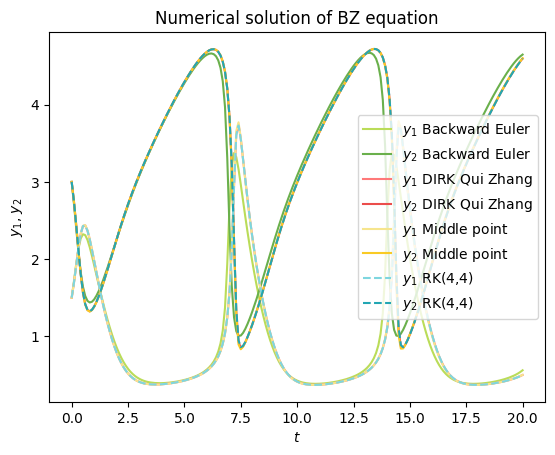

In [6]:
methods = {
    "be": "Backward Euler",
    "dirk_qz": "DIRK Qui Zhang",
    "mp": "Middle point",
    "rk44": "RK(4,4)"
}
colors      = ["#badc58", "#ff7979", "#f6e58d", "#7ed6df"]
dark_colors = ["#6ab04c", "#eb4d4b", "#f9ca24", "#22a6b3"]

for i,(tag, scheme) in enumerate(methods.items()):
    data = np.loadtxt(f"belousov_zhabotinsky_demo/bz_{tag}.dat")
    t  = data[:,0]
    y1 = data[:,1]
    y2 = data[:,2]
    
    line = "--" if tag == "rk44" else "-"
    
    plt.plot(t, y1, line, color=colors[i]     , label=f"$y_1$ {scheme}")
    plt.plot(t, y2, line, color=dark_colors[i], label=f"$y_2$ {scheme}")

plt.legend()
plt.xlabel("$t$"); plt.ylabel("$y_1$, $y_2$")
plt.title("Numerical solution of BZ equation")
plt.show()

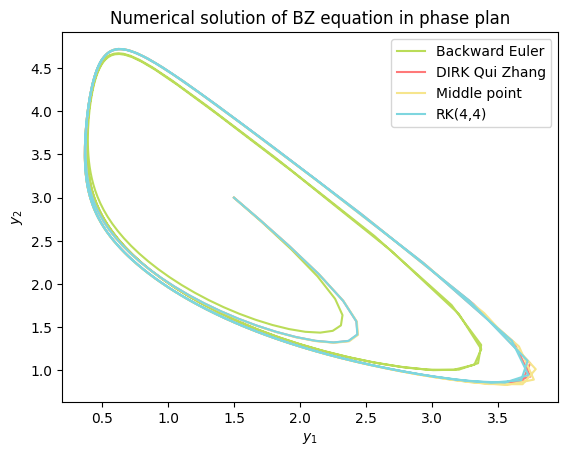

In [7]:
for i,(tag, scheme) in enumerate(methods.items()):
    data = np.loadtxt(f"belousov_zhabotinsky_demo/bz_{tag}.dat")
    y1 = data[:,1]
    y2 = data[:,2]
    
    line = "--" if scheme == "rk44" else "-"
    plt.plot(y1, y2, line, color=colors[i], label=scheme)

plt.legend()
plt.xlabel("$y_1$"); plt.ylabel("$y_2$")
plt.title("Numerical solution of BZ equation in phase plan")
plt.show()